### Dpi Setting

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

# Dependencies

### Python

In [ ]:
!pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.0-2.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%load_ext rpy2.ipython

### R

In [ ]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘RcppArmadillo’

trying URL 'https://cran.rstudio.com/src/contrib/RcppArmadillo_14.4.2-1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/WaveSampling_0.1.4.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpEVsGEe/downloaded_packages’
Loading required package: Matrix
Loading required package: sampling
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘lpSolve’

trying URL 'https://cran.rstudio.com/src/contrib/lpSolve_5.6.23.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/sampling_2.10.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpEVsGEe/downloaded_packages’
Loading required package: BalancedSampling
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BalancedSa

### Imports

In [ ]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Scores in R

In [ ]:
def scores(coords, probs, n, N, sample_idx):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]

    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

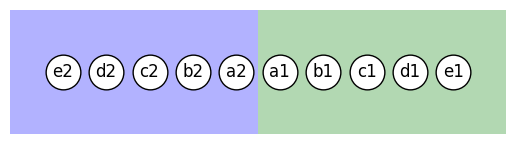

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [ ]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

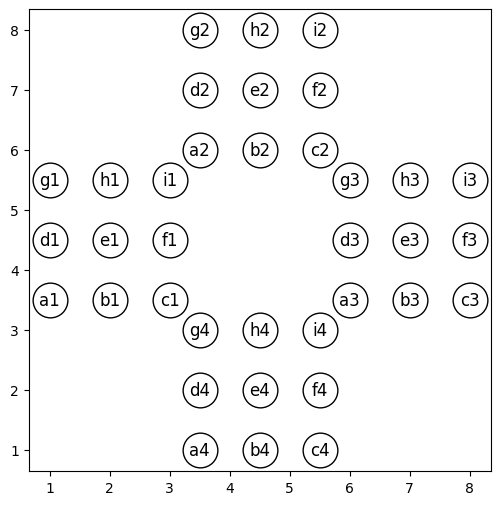

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [ ]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

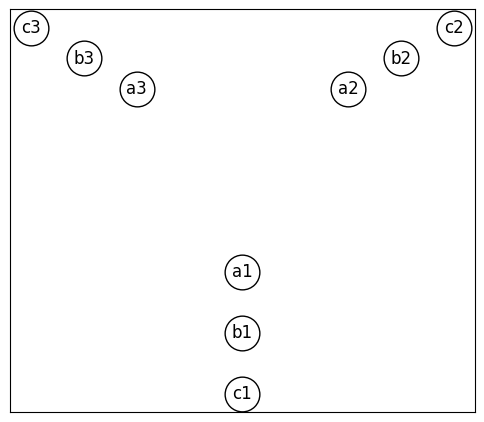

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [ ]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

## Methods

In [ ]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=n_zones, tolerance=5).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (2, 2)),
        "K-Means (5, 5)": k_means_samples(coords, probs, n, num_samples, (5, 5)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

## Initial Population

In [ ]:
n = 4 # Number of item in each sample (number of clusters)
sample_cnt = 20 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [ ]:
######### GRID
# grid_size = 20
# N = grid_size**2
# coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
# N = 400
# coords = rng.random_coordinates((N, 2))

######### CLUSTRED
n_clusters = 4
cluster_std = 0.05
N = 400
coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))
idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
# swiss_df = pd.read_csv('/content/swiss.csv')
# coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
# N = len(coords)

### Probabilities

Uncomment each one you would like to get result from

In [ ]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
probs = np.sort(rng.unequal_probabilities(n, N))

## Results

### Plotting coords

[array([[ 2.77000000e+02,  6.82059795e-01, -4.18547862e-02,
         1.40628582e-02],
       [ 2.82000000e+02,  6.86387122e-01, -2.36682613e-02,
         1.42855185e-02],
       [ 2.89000000e+02,  6.95940015e-01, -4.89374257e-02,
         1.47976128e-02],
       [ 3.01000000e+02,  7.25103928e-01, -8.85491790e-03,
         1.54665384e-02],
       [ 3.02000000e+02,  7.25842345e-01, -9.94560532e-02,
         1.54888709e-02],
       [ 3.04000000e+02,  7.29159281e-01, -5.74003527e-02,
         1.55483047e-02],
       [ 3.10000000e+02,  7.41171615e-01, -3.46747066e-02,
         1.56221421e-02],
       [ 3.12000000e+02,  7.45670911e-01, -2.96162843e-02,
         1.57092837e-02],
       [ 3.13000000e+02,  7.47743108e-01, -8.14060367e-02,
         1.58274418e-02],
       [ 3.14000000e+02,  7.48113261e-01, -3.32773268e-02,
         1.58970129e-02],
       [ 3.21000000e+02,  7.54550594e-01, -1.72379865e-02,
         1.60814239e-02],
       [ 3.23000000e+02,  7.59370333e-01, -4.46847117e-02,
     

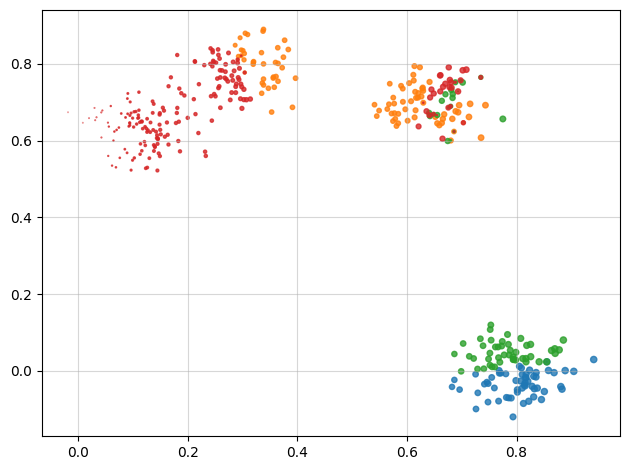

In [ ]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull

density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids
fig, ax = plt.subplots()
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = cluster[:, 1:3]
    cluster_color = plt.cm.tab10(cluster_idx % 10)
    cmap = plt.get_cmap('tab10')         # get the colormap object
    n_colors = cmap.N                  # how many entries it has
    cluster_color = cmap(cluster_idx % n_colors)    # ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        s=cluster[:, 3] * 1000,
        alpha=0.8,
    )
    ax.grid(alpha=0.5)
    # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()
# ax.show()

### Gathering Data

In [ ]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)

rows = np.array([
    [method, *scores(coords, probs, n, N, s)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


### Tables

Means

In [ ]:
df.groupby("Method").mean()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.090182,0.153673,-0.088479,0.639505
"K-Means (5, 5)",0.119501,0.174333,-0.043611,0.607292
Local Pivotal,0.058047,0.124333,-0.150753,0.910823
Random,0.340992,0.715485,-0.046767,2.766562
UPmaxentropy,0.255124,0.363704,-0.008760,0.655174


STD

In [ ]:
df.groupby("Method").std()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.085573,0.142694,0.085823,0.428623
"K-Means (5, 5)",0.099082,0.150187,0.076992,0.278338
Local Pivotal,0.065524,0.131399,0.064061,1.739721
Random,0.140127,0.466428,0.065424,3.089135
UPmaxentropy,0.206930,0.250088,0.075522,0.280832


Describe

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (2, 2)    20.0  0.090182  0.085573  0.009319  0.019089  0.049517   
K-Means (5, 5)    20.0  0.119501  0.099082  0.005605  0.013447  0.185722   
Local Pivotal     20.0  0.058047  0.065524  0.003742  0.014723  0.020619   
Random            20.0  0.340992  0.140127  0.037594  0.268640  0.378025   
UPmaxentropy      20.0  0.255124  0.206930  0.007450  0.066021  0.227430   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (2, 2)  0.158790  0.270431    20.0  0.153673  0.142694  0.012977   
K-Means (5, 5)  0.201129  0.248865    20.0  0.174333  0.150187  0.012765   
Local Pivotal   0.098911  0.197523    20.0  0.124333  0.131399  0.012675   
Random          0.408629  0.549133    20.0  0.715485  0.466428  0.047937   
UPmaxentropy    0.361093  0.611611    20.0  0.363704  0.250088  0.013302   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (2, 2)  0.027974  0.112861  0.234863  0.521074  20.0 -0.088479   
K-Means (5, 5)  0.058918  0.091420  0.299643  0.502511  20.0 -0.043611   
Local Pivotal   0.015888  0.043014  0.214981  0.361010  20.0 -0.150753   
Random          0.347797  0.534689  1.256003  1.557881  20.0 -0.046767   
UPmaxentropy    0.170540  0.346032  0.556485  0.914501  20.0 -0.008760   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (2, 2)  0.085823 -0.293958 -0.105917 -0.064597 -0.041536  0.022020   
K-Means (5, 5)  0.076992 -0.175494 -0.090028 -0.050716  0.006557  0.065051   
Local Pivotal   0.064061 -0.270521 -0.195395 -0.162747 -0.111566 -0.041185   
Random          0.065424 -0.214362 -0.053650 -0.038882 -0.017719  0.052941   
UPmaxentropy    0.075522 -0.201460 -0.049492  0.023648  0.044874  0.077393   

               Local Balance                                          \
                       count      mean       std       min       25%   
Method                                                                 
K-Means (2, 2)          20.0  0.639505  0.428623  0.347896  0.391700   
K-Means (5, 5)          20.0  0.607292  0.278338  0.185941  0.377619   
Local Pivotal           20.0  0.910823  1.739721  0.299611  0.443249   
Random                  20.0  2.766562  3.089135  0.198159  0.895059   
UPmaxentropy            20.0  0.655174  0.280832  0.105447  0.446892   

                                               
                     50%       75%        max  
Method                                         
K-Means (2, 2)  0.483555  0.731817   2.146172  
K-Means (5, 5)  0.628737  0.723374   1.201182  
Local Pivotal   0.496214  0.591380   8.266059  
Random          1.317799  3.246010  11.489008  
UPmaxentropy    0.679367  0.784152   1.425261

### Plots

##### Color Pallet

In [ ]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [ ]:
def remove_outliers(dataframe, column, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

<ipython-input-21-fab2702018fe>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
<ipython-input-21-fab2702018fe>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
<ipython-input-21-fab2702018fe>:11: DeprecationWarning: DataFrameGroupBy.apply operated on

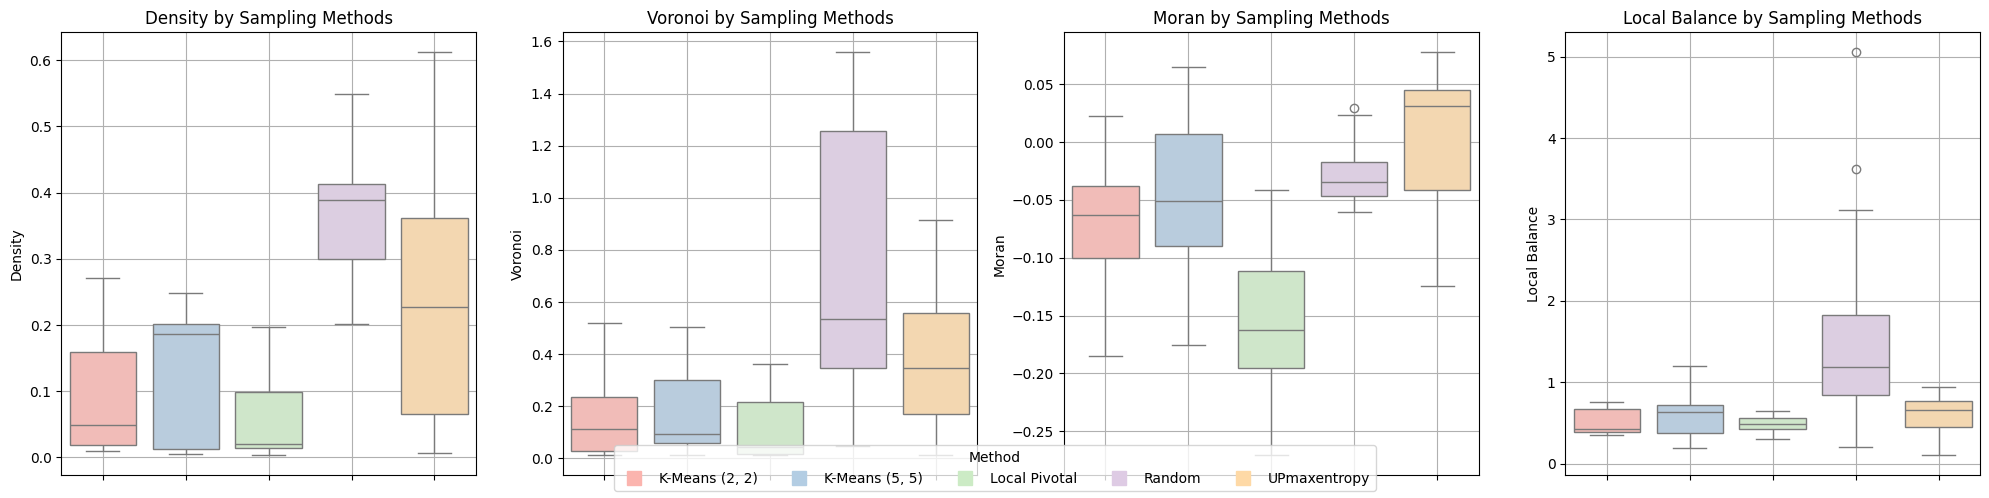

In [ ]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()